# Курсовая работа по фундаментальным концепциям искусственного интеллекта
## Датасет: [Cityscapes Image Pairs](https://www.kaggle.com/datasets/dansbecker/cityscapes-image-pairs)
### Выполнил Сипкин В.Ю. из М8О-114СВ-24

## 1. Описание датасета:

### Датасет Cityscapes предназначен для задач семантической сегментации, то есть для автоматического распознавания и разметки объектов на изображениях с реальных улиц Германии.
### Он включается в себя 2975 картинок для обучения и 500 - для валидации, каждая их которых иммет размер 256x512 пикселей и содержит два картиники: оригинальная фотография находится в левой части изображения, а размеченное изображение по средством семантической сегментации — в правой.

### Подключаем необходимые импорты

In [27]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import Cityscapes
import kagglehub
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

### Скачиваем датасет с Kaggle
[Oблако с датасетом](https://drive.google.com/drive/folders/1rgUycCkRIocoMq571qOJPOVlfM9IoMRK?usp=drive_link)

In [51]:
path_datasets = r"C:\Users\Vladix35\Desktop\Learning\MAI\ML\Coursework\cityscapes_datasets"
path = kagglehub.dataset_download("dansbecker/cityscapes-image-pairs")
os.rename(path, path_datasets)

Resuming download from 136314880 bytes (75177632 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/dansbecker/cityscapes-image-pairs?dataset_version_number=1 (136314880/211492512) bytes left.


100%|██████████| 202M/202M [00:17<00:00, 4.33MB/s]

Extracting files...


### Создаём функцию для загрузки нашего датасета

In [8]:
class CityscapeImagePairDataset(Dataset):
    def __init__(
        self,
        root=r'C:\Users\Vladix35\Desktop\Learning\MAI\ML\Coursework\cityscapes_datasets\cityscapes_data',
        image_set='train',
        transform=None
    ):
        super().__init__()
        self.data_path = os.path.join(root, image_set)
        self.image_set = image_set
        self.images = [
            fname for fname in os.listdir(self.data_path) 
            if fname.endswith(('.jpg', '.png'))
        ]
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.data_path, self.images[index])
        image_pair = Image.open(img_path)
        
        w, h = image_pair.size
        
        original_image = image_pair.crop((0, 0, w//2, h))
        labeled_image = image_pair.crop((w//2, 0, w, h))
        
        if self.transform:
            original_image = self.transform(original_image)
            labeled_image = self.transform(labeled_image)
        
        return original_image, labeled_image
    
    def __len__(self):
        return len(self.images)

### Создание датасетов для обучения (train) и валидации (val), использя класс CityscapeImagePairDataset, который разбивает изображения на пары(оригинальное и размеченное), применяет к ним преобразования (изменение размера, преобразование в тензор и нормализация), и создаёт DataLoader для батчевого обучения:

In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),           
    transforms.ToTensor(),                  
    transforms.Normalize((0.5, 0.5, 0.5),    
                         (0.5, 0.5, 0.5))
])

train_dataset = CityscapeImagePairDataset(
    root=r'C:\Users\Vladix35\Desktop\Learning\MAI\ML\Coursework\cityscapes_datasets\cityscapes_data',
    image_set='train',
    transform=transform
)

val_dataset = CityscapeImagePairDataset(
    root=r'C:\Users\Vladix35\Desktop\Learning\MAI\ML\Coursework\cityscapes_datasets\cityscapes_data',
    image_set='val',
    transform=transform
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
)

### Выведем размер батчей для датасетов обучения и валидации

In [44]:
for batch in train_dataloader:
    original_images, labeled_images = batch
    print(f"Размер батчей оригинальных картинок датасета для обучения: {original_images.shape}")
    print(f"Размер батчей размеченных картинок датасета для обучения: {labeled_images.shape}")
    break
for batch in val_dataloader:
    original_images, labeled_images = batch
    print(f"Размер батчей оригинальных картинок датасета для валидации: {original_images.shape}")
    print(f"Размер батчей размеченных картинок датасета для валидации: {labeled_images.shape}")
    break

Размер батчей оригинальных картинок датасета для обучения: torch.Size([8, 3, 256, 256])
Размер батчей размеченных картинок датасета для обучения: torch.Size([8, 3, 256, 256])
Размер батчей оригинальных картинок датасета для валидации: torch.Size([4, 3, 256, 256])
Размер батчей размеченных картинок датасета для валидации: torch.Size([4, 3, 256, 256])


### Сравнение датасетов

In [45]:
datasets = {
    'Cityscapes': {
        'size': '5000 изображений (обучение: 2975, валидация: 500)',
        'image_resolution': '1024x2048',
        'num_classes': 19,
        'description': 'Датасет для сегментации городских сцен с подробной разметкой.',
    },
    'Pascal VOC': {
        'size': '1464 изображения (обучение)',
        'image_resolution': '500x375',
        'num_classes': 20,
        'description': 'Популярный датасет для классификации, детекции объектов и сегментации.',
    },
    'COCO': {
        'size': '330,000 изображений',
        'image_resolution': 'разное (300x300 до 800x800)',
        'num_classes': 80,
        'description': 'Крупномасштабный датасет для детекции объектов, сегментации и описания изображений.',
    },
    'ADE20K': {
        'size': '20,210 изображений',
        'image_resolution': 'разное',
        'num_classes': 150,
        'description': 'Датасет для семантической сегментации с разнообразными типами сцен.',
    }
}

for dataset, info in datasets.items():
    print(f"Датасет: {dataset}")
    print(f"  Размер: {info['size']}")
    print(f"  Разрешение изображений: {info['image_resolution']}")
    print(f"  Количество классов: {info['num_classes']}")
    print(f"  Описание: {info['description']}")
    print("-" * 40)

Датасет: Cityscapes
  Размер: 5000 изображений (обучение: 2975, валидация: 500)
  Разрешение изображений: 1024x2048
  Количество классов: 19
  Описание: Датасет для сегментации городских сцен с подробной разметкой.
----------------------------------------
Датасет: Pascal VOC
  Размер: 1464 изображения (обучение)
  Разрешение изображений: 500x375
  Количество классов: 20
  Описание: Популярный датасет для классификации, детекции объектов и сегментации.
----------------------------------------
Датасет: COCO
  Размер: 330,000 изображений
  Разрешение изображений: разное (300x300 до 800x800)
  Количество классов: 80
  Описание: Крупномасштабный датасет для детекции объектов, сегментации и описания изображений.
----------------------------------------
Датасет: ADE20K
  Размер: 20,210 изображений
  Разрешение изображений: разное
  Количество классов: 150
  Описание: Датасет для семантической сегментации с разнообразными типами сцен.
----------------------------------------


## 2. Статистика датасета:

### Функция стратистики датасета:

In [46]:
def calculate_dataset_statistics(dataset):
    stats = {
        'num_records': 0,        # количество записей
        'num_fields': 0,         # количество полей в одной записи (оригинальное и аннотированное изображение)
        'record_size_bytes': 0,  # объём одной записи в байтах
        'num_features': 0,       # количество фичей (например, пиксели * каналы)
        'class_distribution': {},# процентное разбиение по классам (если доступно)
        'missing_values': 0,     # количество пропусков
        'data_types': {}         # типы данных
    }
    record_sizes = []
    for idx in range(len(dataset)):
        original_image, labeled_image = dataset[idx]
        stats['num_records'] += 1
        stats['num_fields'] = 2
        record_size = (
            original_image.numel() * original_image.element_size() +
            labeled_image.numel() * labeled_image.element_size()
        )
        record_sizes.append(record_size)
        stats['num_features'] = original_image.numel()
        data_type = original_image.dtype
        stats['data_types'][str(data_type)] = stats['data_types'].get(str(data_type), 0) + 1
    stats['record_size_bytes'] = np.mean(record_sizes)
    class_counts = {}
    for _, labeled_image in dataset:
        unique_classes, counts = np.unique(labeled_image.numpy(), return_counts=True)
        for cls, cnt in zip(unique_classes, counts):
            class_counts[cls] = class_counts.get(cls, 0) + cnt
    total_pixels = sum(class_counts.values())
    stats['class_distribution'] = {
        cls: round((cnt / total_pixels) * 100, 2) for cls, cnt in class_counts.items()
    }
    stats['missing_values'] = len([fname for fname in dataset.images if not os.path.exists(fname)])
    return stats


### Создание статистики датасетов для обучения (train) и валидации (val):

In [47]:
train_stats = calculate_dataset_statistics(train_dataset)
print("Статистика датасета для обучения:")
for key, value in train_stats.items():
    print(f"{key}: {value}")

val_stats = calculate_dataset_statistics(val_dataset)
print("Статистика датасета для валидации:")
for key, value in val_stats.items():
    print(f"{key}: {value}")

Статистика датасета для обучения:
num_records: 2975
num_fields: 2
record_size_bytes: 1572864.0
num_features: 196608
class_distribution: {-1.0: 7.58, -0.99215686: 1.37, -0.9843137: 0.97, -0.9764706: 0.55, -0.96862745: 0.4, -0.9607843: 0.32, -0.9529412: 0.22, -0.94509804: 0.17, -0.9372549: 0.16, -0.92941177: 0.14, -0.92156863: 0.13, -0.9137255: 0.14, -0.90588236: 0.12, -0.8980392: 0.11, -0.8901961: 0.1, -0.88235295: 0.1, -0.8745098: 0.1, -0.8666667: 0.09, -0.85882354: 0.1, -0.8509804: 0.14, -0.84313726: 0.1, -0.8352941: 0.1, -0.827451: 0.11, -0.81960785: 0.11, -0.8117647: 0.09, -0.8039216: 0.12, -0.79607844: 0.16, -0.7882353: 0.16, -0.78039217: 0.11, -0.77254903: 0.21, -0.7647059: 0.24, -0.75686276: 0.14, -0.7490196: 0.41, -0.7411765: 0.19, -0.73333335: 1.75, -0.7254902: 0.59, -0.7176471: 0.47, -0.70980394: 0.35, -0.7019608: 0.19, -0.69411767: 0.24, -0.6862745: 0.15, -0.6784314: 0.19, -0.67058825: 0.13, -0.6627451: 0.18, -0.654902: 0.12, -0.64705884: 0.16, -0.6392157: 0.14, -0.6313726: 0

## 3. Выбор алгоритма с последующим обучением:

### Задача: Сегментация изображений городской местности
#### Задача состоит в том, чтобы сегментировать изображения городских улиц на основе размеченных данных из Cityscapes Image Pairs. В этой задаче мы будем классифицировать каждый пиксель изображения в один из 19 классов, таких как дорога, здания, автомобили, люди и т.д.
### Алгоритм:
#### Для сегментации изображений используется U-Net, который состоит из сжатия, т.е. сначала входное изображение проходит через несколько сверточных слоев с уменьшением размера, что позволяет извлекать высокоуровневые признаки, и их расширения, т.е. затем в модели используются транспонированные сверточные слои, чтобы восстановить пространственные данные и получить изображение, где каждый пиксель принадлежит к одному из классов.
#### Для генератора используется модификация U-Net с добавлением Instance Normalization и Dropout для улучшения качества модели.

### Бенчмарки

In [54]:
data = {
    "Параметр": [
        "Датасет", "Количество изображений", "Разрешение изображений", "Классы сегментации", 
        "Алгоритм", "Оптимизатор", "Метрики", "Функция потерь", "Методика испытаний", 
        "Среднее время на эпоху", "Программное обеспечение", "Оборудование", "Результаты"
    ],
    "Значение": [
        "Cityscapes Image Pairs", 
        "5,000 обучающих, 500 валидационных, 1,525 тестовых изображений", 
        "2048x1024", 
        "19 классов (дороги, здания, люди, автомобили и др.)", 
        "U-Net (с дополнениями: Dropout, Instance Normalization, GAN)", 
        "Adam (с learning rate 0.0002, β1=0.5, β2=0.999)", 
        "- Mean IoU (mIoU): Средний Intersection over Union для 19 классов\n- Pixel Accuracy: Точность предсказания пикселей\n- Dice Coefficient: Мера схожести для сегментации", 
        "- GAN Loss: Для обучения генератора (с использованием MSE Loss)\n- Pixel-wise L1 Loss: Для минимизации различий между предсказанными и настоящими значениями пикселей", 
        "- Обучение на 5,000 обучающих изображениях\n- Тестирование на 1,525 тестовых изображениях\n- Использование увеличения данных (сдвиги, повороты и т.д.) для улучшения генерализации модели", 
        "Зависит от размера батча и мощности оборудования, но обычно составляет от 30 минут до 1 часа на эпоху", 
        "PyTorch", 
        "GPU (NVIDIA, рекомендуется Tesla или RTX)", 
        "mIoU: 70-75%, Pixel Accuracy: > 90% (для модели, обученной на 10 эпохах)"
    ]
}
benchmark_df = pd.DataFrame(data)
print(benchmark_df)

                   Параметр                                           Значение
0                   Датасет                             Cityscapes Image Pairs
1    Количество изображений  5,000 обучающих, 500 валидационных, 1,525 тест...
2    Разрешение изображений                                          2048x1024
3        Классы сегментации  19 классов (дороги, здания, люди, автомобили и...
4                  Алгоритм  U-Net (с дополнениями: Dropout, Instance Norma...
5               Оптимизатор    Adam (с learning rate 0.0002, β1=0.5, β2=0.999)
6                   Метрики  - Mean IoU (mIoU): Средний Intersection over U...
7            Функция потерь  - GAN Loss: Для обучения генератора (с использ...
8        Методика испытаний  - Обучение на 5,000 обучающих изображениях\n- ...
9    Среднее время на эпоху  Зависит от размера батча и мощности оборудован...
10  Программное обеспечение                                            PyTorch
11             Оборудование          GPU (NVIDIA, ре

### Пример алгоритма машнного обучения:
#### В данном коде также вместе с U-Net используется GAN, где Generator обучается генерировать сегментированные изображения на основе входных данных, а Discriminator оценивает реальные и сгенерированные изображения, помогая улучшить качество сегментации.
#### Для каждой эпохи обучения модели используются потери генератора для обучения сегментации GAN loss и потери, основанные на разнице между предсказанными и настоящими значениями пикселей Pixel-wise loss

In [10]:
class UNetDown(nn.Module): 
    def __init__(self, in_channels: int, out_channels: int, normalize: bool = True, dropout: float = 0.0):
        super(UNetDown, self).__init__()
        
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout: float = 0.0):
        super(UNetUp, self).__init__()
        
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x: torch.Tensor, skip_input: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return torch.cat((x, skip_input), dim=1)

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)
        
        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64) 
        
        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        
        return self.final(u7)

class Discriminator(nn.Module):
    def __init__(self, in_channels: int = 3):
        super(Discriminator, self).__init__()
        
        def block(in_c: int, out_c: int, normalization: bool = True):
            layers = [nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(in_channels * 2, 64, normalization=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, kernel_size=4, padding=1, bias=False)
        )
    
    def forward(self, image_A: torch.Tensor, image_B: torch.Tensor) -> torch.Tensor:
        image_input = torch.cat((image_A, image_B), dim=1)
        return self.model(image_input)

def weights_init_normal(m: nn.Module):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [11]:
is_cuda = torch.cuda.is_available()

generator = GeneratorUNet()
discriminator = Discriminator()

criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

if is_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_pixelwise = criterion_pixelwise.cuda()

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


def sample_images(generator, val_dataloader, epoch, save_dir="images"):
    os.makedirs(save_dir, exist_ok=True)
    original_image, labeled_image = next(iter(val_dataloader))
    if is_cuda:
        original_image = original_image.cuda()
        labeled_image = labeled_image.cuda()
    generated_image = generator(original_image)
    image_sample = torch.cat((original_image.data, generated_image.data, labeled_image.data), -2)
    grid = make_grid(image_sample, nrow=4, normalize=True).cpu().permute(1, 2, 0)
    plt.imshow(grid)
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    plt.savefig(f"{save_dir}/epoch_{epoch}.png")
    plt.show()

n_epochs = 10
n_batches = len(train_dataloader)


Epoch 1/10: 100%|██████████| 372/372 [02:46<00:00,  2.23batch/s, loss_D=0.153, loss_G=16.7] 


Average Generator Loss: 21.0686
Average Discriminator Loss: 0.2212


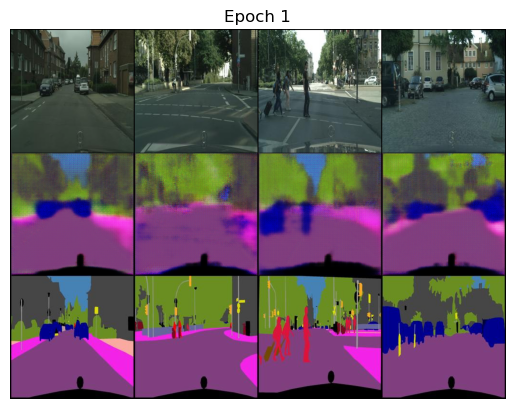

Epoch 2/10: 100%|██████████| 372/372 [02:44<00:00,  2.26batch/s, loss_D=0.0569, loss_G=16.4]


Average Generator Loss: 16.6256
Average Discriminator Loss: 0.0984


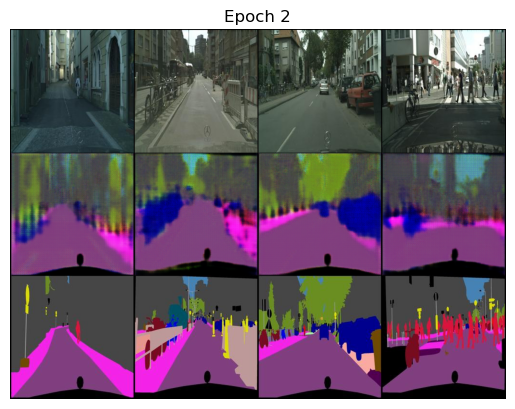

Epoch 3/10: 100%|██████████| 372/372 [02:39<00:00,  2.33batch/s, loss_D=0.0423, loss_G=14.7]


Average Generator Loss: 14.9654
Average Discriminator Loss: 0.0882


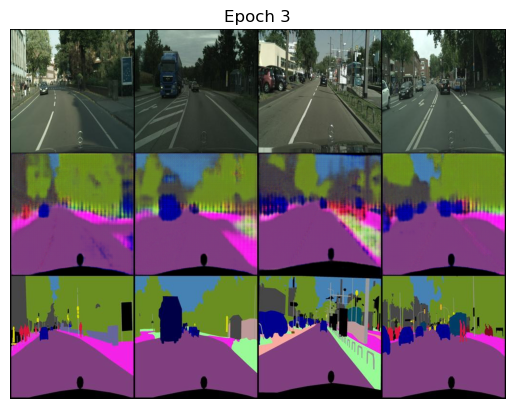

Epoch 4/10: 100%|██████████| 372/372 [02:37<00:00,  2.36batch/s, loss_D=0.0386, loss_G=11.6]


Average Generator Loss: 13.9898
Average Discriminator Loss: 0.0821


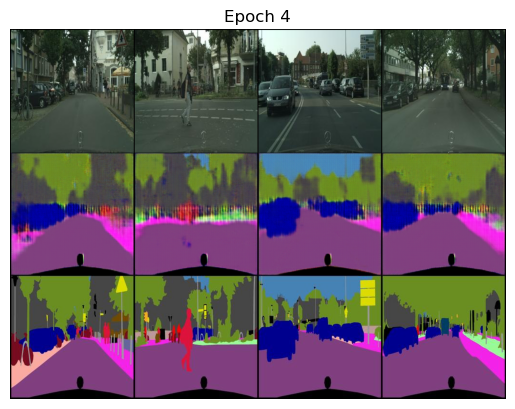

Epoch 5/10: 100%|██████████| 372/372 [02:37<00:00,  2.37batch/s, loss_D=0.0539, loss_G=12.2]


Average Generator Loss: 13.3627
Average Discriminator Loss: 0.0814


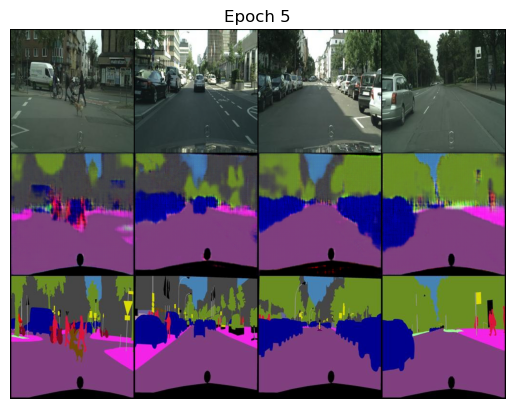

Epoch 6/10: 100%|██████████| 372/372 [02:39<00:00,  2.33batch/s, loss_D=0.0713, loss_G=12.3]


Average Generator Loss: 12.8338
Average Discriminator Loss: 0.0858


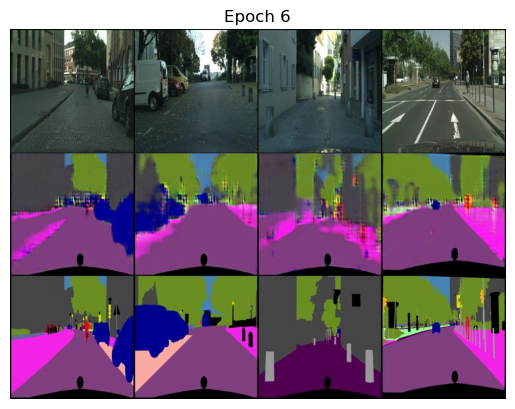

Epoch 7/10: 100%|██████████| 372/372 [02:48<00:00,  2.20batch/s, loss_D=0.0444, loss_G=15.5]


Average Generator Loss: 12.4374
Average Discriminator Loss: 0.0957


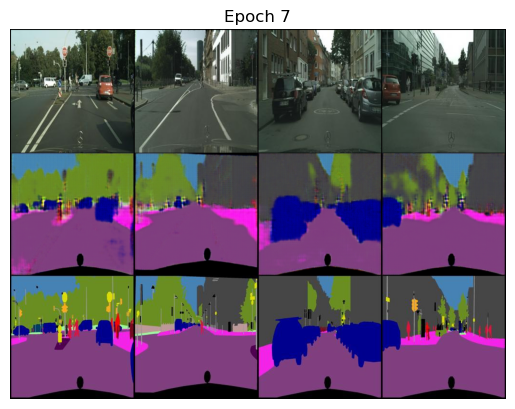

Epoch 8/10: 100%|██████████| 372/372 [02:49<00:00,  2.19batch/s, loss_D=0.0445, loss_G=14.1]


Average Generator Loss: 12.1069
Average Discriminator Loss: 0.0860


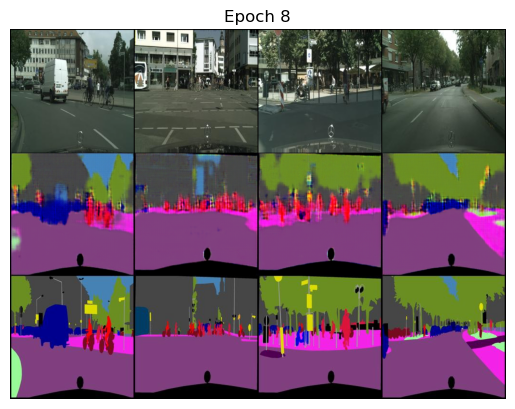

Epoch 9/10: 100%|██████████| 372/372 [02:48<00:00,  2.21batch/s, loss_D=0.0838, loss_G=11.5]


Average Generator Loss: 11.8329
Average Discriminator Loss: 0.0902


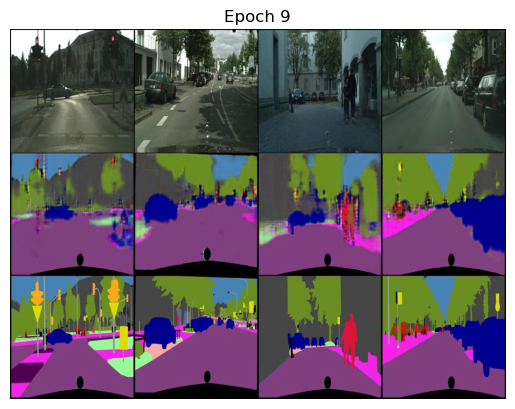

Epoch 10/10: 100%|██████████| 372/372 [02:46<00:00,  2.23batch/s, loss_D=0.15, loss_G=11.3]  


Average Generator Loss: 11.4826
Average Discriminator Loss: 0.1055


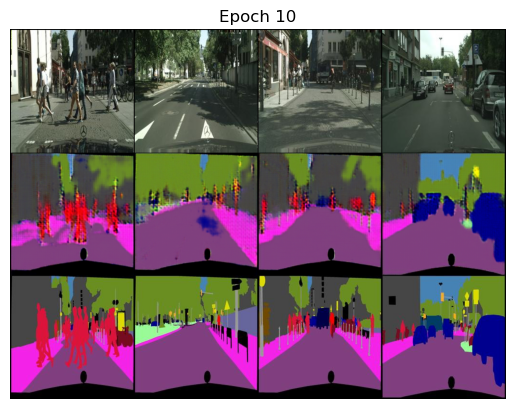

In [12]:
for epoch in range(n_epochs):
    generator.train()
    discriminator.train()

    train_loss_G = 0
    train_loss_D = 0

    with tqdm(train_dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch + 1}/{n_epochs}")
        for original_images, labeled_images in tepoch:
            batch_size = original_images.size(0)

            real_label = torch.ones((batch_size, 1, 16, 16), requires_grad=False).cuda() if is_cuda else torch.ones((batch_size, 1, 16, 16), requires_grad=False)
            fake_label = torch.zeros((batch_size, 1, 16, 16), requires_grad=False).cuda() if is_cuda else torch.zeros((batch_size, 1, 16, 16), requires_grad=False)

            if is_cuda:
                original_images = original_images.cuda()
                labeled_images = labeled_images.cuda()

            optimizer_G.zero_grad()

            generated_images = generator(original_images)
            pred_fake = discriminator(generated_images, original_images)
            loss_GAN = criterion_GAN(pred_fake, real_label)
            loss_pixel = criterion_pixelwise(generated_images, labeled_images)
            loss_G = loss_GAN + 100 * loss_pixel

            loss_G.backward()
            optimizer_G.step()

            optimizer_D.zero_grad()

            pred_real = discriminator(labeled_images, original_images)
            loss_real = criterion_GAN(pred_real, real_label)
            pred_fake = discriminator(generated_images.detach(), original_images)
            loss_fake = criterion_GAN(pred_fake, fake_label)
            loss_D = 0.5 * (loss_real + loss_fake)

            loss_D.backward()
            optimizer_D.step()

            train_loss_G += loss_G.item()
            train_loss_D += loss_D.item()

            tepoch.set_postfix(loss_G=loss_G.item(), loss_D=loss_D.item())

    print(f"Average Generator Loss: {train_loss_G / n_batches:.4f}")
    print(f"Average Discriminator Loss: {train_loss_D / n_batches:.4f}")

    sample_images(generator, val_dataloader, epoch + 1)

    torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
    torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")

### Результаты выполднения программы:
#### Спустя 10 эпох среднии потери генератора и дискриминатора уменьшились примерно в два раза, что является хорошим результатом для задач сегментации на сложных данных, таких как Cityscapes.

## 4. Класстеризация датасета Cityscapes

### Для кластеризации пикселей изображений из датасета используется алгоритм KMeans. Каждое изображение преобразуется в массив пикселей, кластеризуется, а затем результаты преобразуются обратно в формат изображения.Здесь выполняется класстеризация для пяти изображений датасета

C:\Users\Vladix35\AppData\Local\Temp\ipykernel_13428\629837327.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cluster_colors = plt.cm.get_cmap('tab10', 5)


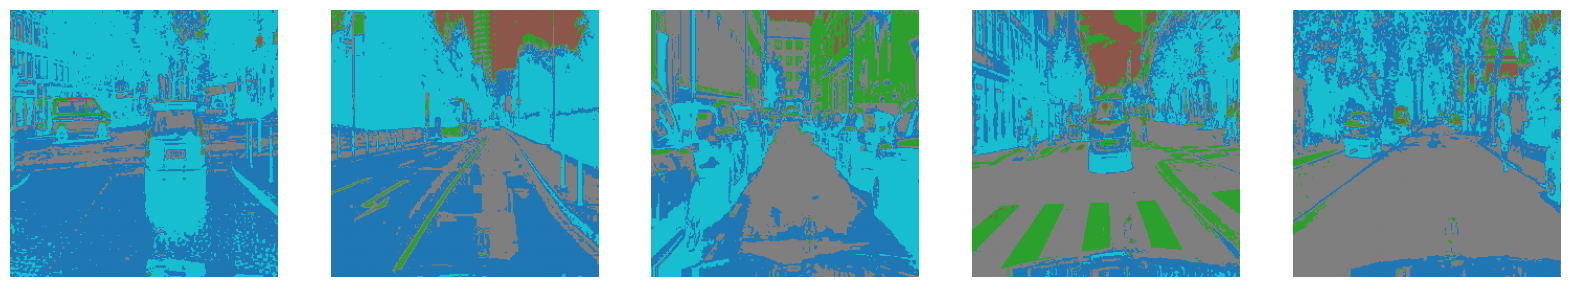

In [25]:
kmeans = KMeans(n_clusters=5, random_state=42)
image_data = []
for images, _ in train_dataloader:
    batch_pixels = images.permute(0, 2, 3, 1).reshape(-1, 3)
    image_data.append(batch_pixels)
image_data = torch.cat(image_data, dim=0).cpu().numpy()
kmeans.fit(image_data)
clusters = kmeans.predict(image_data)
clustered_images = clusters.reshape(-1, images.size(2), images.size(3))
plt.figure(figsize=(20, 20))
cluster_colors = plt.cm.get_cmap('tab10', 5)
for j in range(5):
    plt.subplot(1, 5, j+1)
    img = clustered_images[j]
    img_color = cluster_colors(img % 5)

    plt.imshow(img_color)
    plt.axis('off')
plt.show()

## 5. Outliers (выбросы)

### Для оценки выбросов подходит вычисление стандратного отклонения Z-Score для поиска выбросов в каждом пикселе по каналам RGB. Затем выявляются изображения, содержащие выбросы, и их индексы выводятся на экран. В итоге для первых изображений с выбросами, они восстанавливаются в исходный вид и в результате отображаются:

Количество выбросов в канале R: 3461685
Количество выбросов в канале G: 5086635
Количество выбросов в канале B: 3993246
Индексы изображений с выбросами: [   0    0    0 ... 2974 2974 2974]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


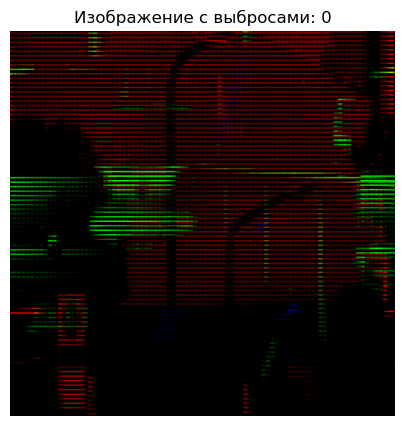

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


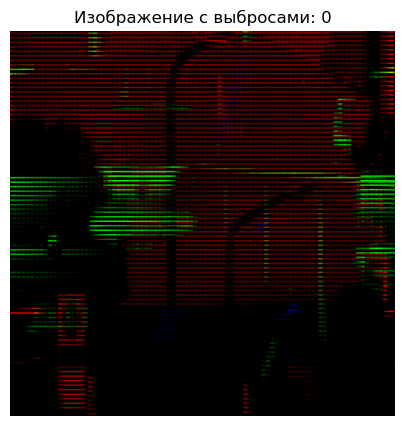

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


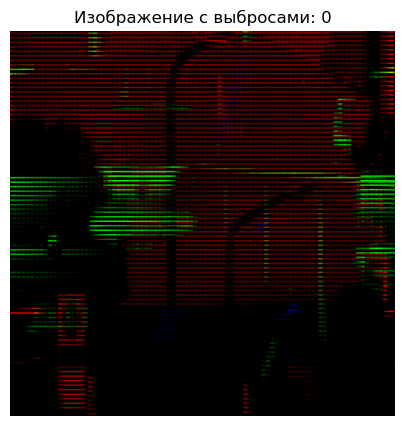

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


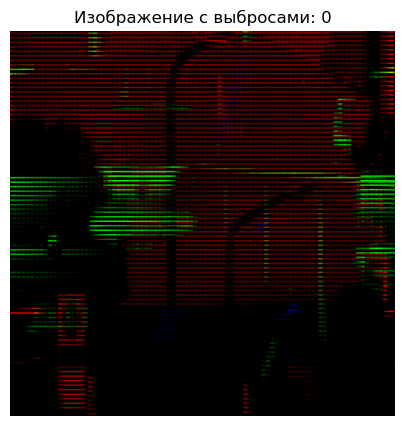

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


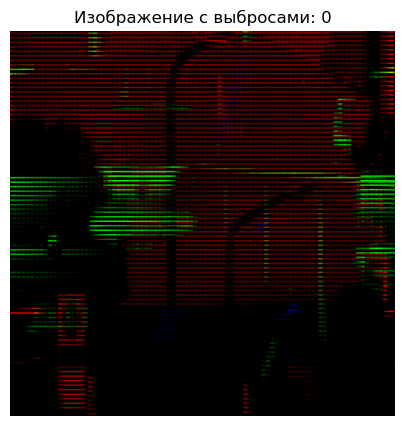

In [32]:
image_data = []
for images, _ in train_dataloader:
    batch_pixels = images.permute(0, 2, 3, 1).reshape(-1, 3)
    image_data.append(batch_pixels)
image_data = torch.cat(image_data, dim=0).cpu().numpy()
z_scores = zscore(image_data, axis=0)
outliers = np.abs(z_scores) > 3
outlier_indices = np.where(outliers)
print(f"Количество выбросов в канале R: {np.sum(outliers[:, 0])}")
print(f"Количество выбросов в канале G: {np.sum(outliers[:, 1])}")
print(f"Количество выбросов в канале B: {np.sum(outliers[:, 2])}")
outlier_image_indices = np.unique(outlier_indices[0]) // (images.size(2) * images.size(3))
print(f"Индексы изображений с выбросами: {outlier_image_indices}")
for i in outlier_image_indices[:5]:
    img = image_data[i * images.size(2) * images.size(3):(i + 1) * images.size(2) * images.size(3)]
    img = img.reshape(images.size(1), images.size(2), images.size(3))
    plt.figure(figsize=(5, 5))
    plt.imshow(img.transpose(1, 2, 0))
    plt.axis('off')
    plt.title(f"Изображение с выбросами: {i}")
    plt.show()

## 6. ML systems design

### Описание премеров использование датасета Cityscapes и модели U-Net в продакшине и преимуществ и недостатков в заисимости от применения:

### Автономные транспортные средства:
#### Задача: Использование моделей, таких как U-Net, для сегментации изображений с камер, установленных на автомобиле, с целью выявления объектов (например, дороги, пешеходы, другие автомобили, знаки и т.д.).
#### +: 1. Модель U-Net хорошо подходит для сегментации изображений, что важно для правильной интерпретации окружающей среды;
#### +: 2. Преимущества в скорости и точности при обработке городской местности.
#### -: 1. Высокие требования к вычислительным ресурсам, особенно при обучении модели;
#### -: 2. Невозможность адаптации в реальном времени без дообучения или использования дополнительной обработки данных.

### Мониторинг городской инфраструктуры:
#### Задача: Обработка спутниковых или уличных изображений для мониторинга состояния городских объектов, таких как дороги, здания, парки, для обнаружения повреждений или планирования инфраструктуры.
#### +: 1. Использование моделей для сегментации и классификации объектов на изображениях может помочь в автоматизации анализа городской среды;
#### +: 2. Технология может быть интегрирована в системы умных городов для более эффективного управления.
#### -: 1. Необходимость в большом объёме данных для обучения моделей, чтобы они могли адаптироваться к различным условиям освещения, погодным условиям и другим переменным;
#### -: 2. Ограниченная способность модели обрабатывать нестандартные изображения.

### Картографические и навигационные сервисы:
#### Задача: Сегментация и классификация изображений с целью создания карт, отображающих различные типы объектов, таких как здания, дороги и природные зоны, для использования в приложениях навигации и картографии.
#### +: 1. Модель может точно сегментировать объекты, что полезно для создания подробных карт;
#### +: 2. Использование данных для автоматического обновления карт и улучшения навигации.
#### -: 1. Требуется большое количество меток и данных, чтобы система могла работать в разных географических и климатических условиях;
#### -: 2. Модели могут быть чувствительны к качеству исходных данных, что может привести к ошибкам в анализе.